## Introduction

The current pandemic has triggered an unprecedented amount of published medical research with the aim to find treatments and vaccinations as soon as possible. This has also led to efforts to gather these research publications and conduct text information retrieval and text mining on them. We will use a fragment of the most widely used resource of this kind: CORD-19. This resource has been made available via several outlets, probably the most popular of which is Kaggle:

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

We will use Kaggle's subset stored in the file metadata.csv. 
The data is organised in columns containing the following information (among others):
- Source (e.g. PMC, Medline, etc)
- Publication title
- Journal title
- DOI
- Abstract
- Date of publication



## Goal 🎯
Performing a in-depth Analysis on research publications and conducting text information retrieval and text mining techniques along with Topic modeling, to find answers to questions like:

#### 1. What is the distribution of journals per source?
#### 2. What are the main clusters?
#### 3. For each cluster, what are the most representative words?
#### 4. What are the most common topics?

### Importing Libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk
nltk.download('stopwords')
import string
string.punctuation

stopwords = nltk.corpus.stopwords.words('english')

from transformers import BertTokenizer
import torch
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
import warnings
import pyLDAvis.gensim_models
import gensim.models.phrases as gen
from gensim.models.coherencemodel import CoherenceModel
import re, nltk, spacy, gensim


# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhuvn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. What is the distribution of journals per source?
Identifying the 10 most frequent journals. Then, for each publication source, displaying the distribution of publications in each journal. The final result will be presented as a clustered column chart.

#### Since the data dataset is huge loading just 200000 rows

In [9]:
df = pd.read_csv("metadata.csv",nrows=200000)

#### Grouping by source to get the distribution of journal

In [10]:
new_df = df.value_counts(subset=['source_x', 'journal']).reset_index(name="count")

In [11]:
new_df

,source_x,journal,count
0,Medline,BMJ,2862
1,Medline,Journal of virology,2154
2,BioRxiv,bioRxiv,2036
3,PMC,Reactions Weekly,1602
4,Medline,Nature,1301
...,...,...,...
20495,PMC,Modelling the Socio-Economic Implications of S...,1
20496,PMC,Models of Emergency Psychiatric Services That ...,1
20497,PMC,Modern Biotechnology,1
20498,PMC,Modern Geopolitics of Eastern Mediterranean Hy...,1


#### Getting the top 10 most frequent Journals

In [12]:
df['journal'].value_counts()[:10]

BMJ                    2986
Journal of virology    2154
bioRxiv                2039
Reactions Weekly       1608
Nature                 1549
PLoS One               1110
JAMA                   1069
Surgical endoscopy      974
Science                 821
Lancet                  789
Name: journal, dtype: int64

#### Filtering the data to keep just the top 10 most frequent Journals

In [13]:
journals_to_keep = ['BMJ','Journal of virology','bioRxiv','Reactions Weekly','Nature','PLoS One','JAMA','Surgical endoscopy','Science','Lancet' ]

In [14]:
new_df = new_df[new_df.journal.isin(journals_to_keep)]

#### Plotting the distribution using seaborn catplot

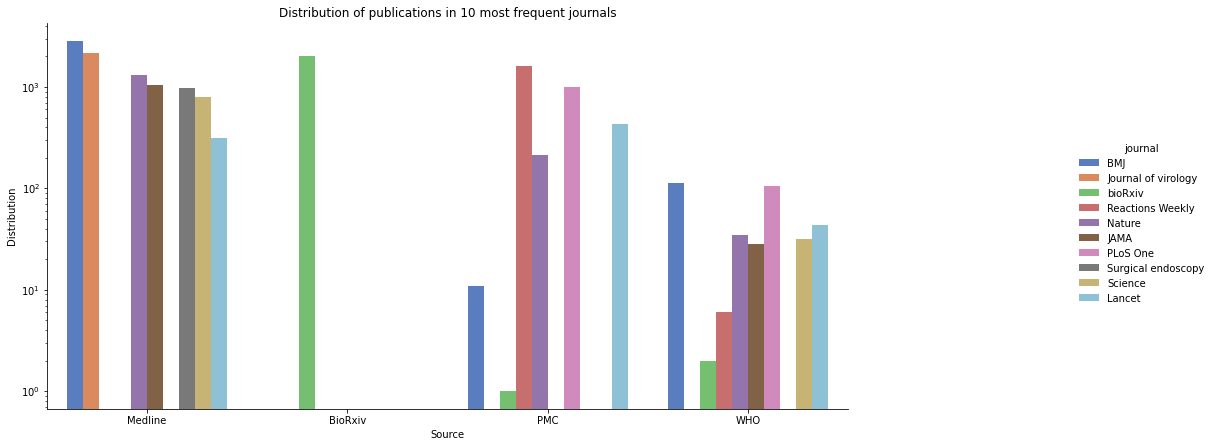

In [18]:

# grouped barplot
g = sns.catplot(x="source_x", y=new_df['count'], hue="journal",
                   data=new_df, kind="bar",
                   height=5, palette="muted", legend=True, log=True)

g.fig.set_figheight(6)
g.fig.set_figwidth(18)
plt.title('Distribution of publications in 10 most frequent journals')
plt.xlabel('Source')
plt.ylabel('Distribution')


plt.show()

#### Different colours represent 10 frequent journals distribution according to the source, Altough there are 7 sources we see just 4 here because eighter they are zeros or more rows from the data are required...! 
#### We can infer Medline to be the top source containing mostly all the journals

## 2. What are the main clusters?
Using the text from the abstracts, we will cluster the data set and visualise the clusters. To cluster the data, we use KMeans. Choosing a reasonable metric to determine the similarity between abstracts, and choosing a reasonable number of clusters.To visualise the clusters, we produce a 2D plot where the axes represent a 2Drepresentation of each document, each document is represented as a marker, and the colour of the marker indicates the cluster to which the document belongs. 

#### For clustering analysis we start by using just 10000 rows to save time and again load the data

In [19]:
df = pd.read_csv("metadata.csv",nrows=10000)

#### Dropping nan values from the abstract column

In [20]:
df = df.dropna(subset=['abstract'])
df['abstract'] = df['abstract'].astype(str)
df.isnull().sum()

cord_uid               0
sha                  251
source_x               0
title                  0
doi                    0
pmcid                  0
pubmed_id              0
license                0
abstract               0
publish_time           0
authors               39
journal               39
mag_id              7853
who_covidence_id    7853
arxiv_id            7853
pdf_json_files       251
pmc_json_files      1881
url                    0
s2_id               7853
dtype: int64

#### Selecting just the abstract column from the dataframe

In [21]:
df = pd.DataFrame(df['abstract'])

In [22]:
df

,abstract
0,OBJECTIVE: This retrospective chart review des...
1,Inflammatory diseases of the respiratory tract...
2,Surfactant protein-D (SP-D) participates in th...
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,Respiratory syncytial virus (RSV) and pneumoni...
...,...
9994,An electrophoretic survey of samples of the ge...
9995,SUMMARY: By indirect immunofluorescence on pig...
9996,The cross‐reactivity of an immunological probe...
9998,Summary: The mucosal immune system of mammals ...


#### Creating a function to clean the text, we'll also add our own custom stopwords which include some common words used in research papers, which can be removed

In [25]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]


stopwords.extend(custom_stop_words)


# A function to prepare the text 
def clean(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text.lower())
    words = text.split(" ")
    words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
    words = [re.sub('\s+', ' ', sent) for sent in words]
    words = [re.sub("\'", "", sent) for sent in words]
    words = [w for w in words if not len(w) < 2]
    words = [w for w in words if w not in stopwords]
    words = [lmtzr.lemmatize(w) for w in words]
    words = ' '.join([str(w) for w in words])
    return words




#### Applying the function on the abstract text

In [26]:
df["clean_abstract"] = df["abstract"].apply(clean)

#### Using the BertTokenizer to tokenize the data

In [27]:
def sen_to_vec(sentence):
    tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
    tokens=tokenizer.tokenize(sentence)
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    T=624 
    padded_tokens=tokens +['[PAD]' for _ in range(T-len(tokens))]
    attn_mask=[ 1 if token != '[PAD]' else 0 for token in padded_tokens  ]
    seg_ids=[0 for _ in range(len(padded_tokens))]
    sent_ids=tokenizer.convert_tokens_to_ids(padded_tokens)
    return np.array(sent_ids)

In [28]:
df["array"] = df["clean_abstract"].apply(sen_to_vec)
df.head()

,abstract,clean_abstract,array
0,OBJECTIVE: This retrospective chart review des...,objective retrospective chart review describes...,"[101, 7863, 15354, 3673, 3319, 5577, 4958, 517..."
1,Inflammatory diseases of the respiratory tract...,inflammatory disease respiratory tract commonl...,"[101, 20187, 4295, 16464, 12859, 4141, 3378, 8..."
2,Surfactant protein-D (SP-D) participates in th...,surfactant protein sp participates innate resp...,"[101, 14175, 18908, 4630, 5250, 11867, 17257, ..."
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...,endothelin amino acid peptide diverse biologic...,"[101, 2203, 14573, 18809, 13096, 5648, 25117, ..."
4,Respiratory syncytial virus (RSV) and pneumoni...,respiratory syncytial virus rsv pneumonia viru...,"[101, 16464, 26351, 22123, 4818, 7865, 12667, ..."


#### Storing tokenized array in a different dataframe

In [29]:
final_df = pd.DataFrame(df["array"])

#### Creating a dataframe out of tokenized array and filling nans with zeros

In [30]:
final_df = final_df.pop('array').apply(pd.Series)
final_df = final_df.fillna(0)
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13061,13062,13063,13064,13065,13066,13067,13068,13069,13070
0,101.0,7863.0,15354.0,3673.0,3319.0,5577.0,4958.0,5178.0,4328.0,6779.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101.0,20187.0,4295.0,16464.0,12859.0,4141.0,3378.0,8319.0,2537.0,9152.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101.0,14175.0,18908.0,4630.0,5250.0,11867.0,17257.0,25605.0,3433.0,15938.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101.0,2203.0,14573.0,18809.0,13096.0,5648.0,25117.0,7578.0,6897.0,4023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101.0,16464.0,26351.0,22123.0,4818.0,7865.0,12667.0,2615.0,18583.0,7865.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Using PCA to reduce the dimensionality of tokenized array data to n_components = 2, so it can be visualized easily

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_PCA=pca.fit_transform(final_df)

print(final_df.shape)
print(X_PCA.shape)

(7853, 13071)
(7853, 2)


#### Getting the best k value for our Kmeans Model

In [32]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_PCA)
    distortions.append(kmeanModel.inertia_)

#### Elbow method to figure out the best K value

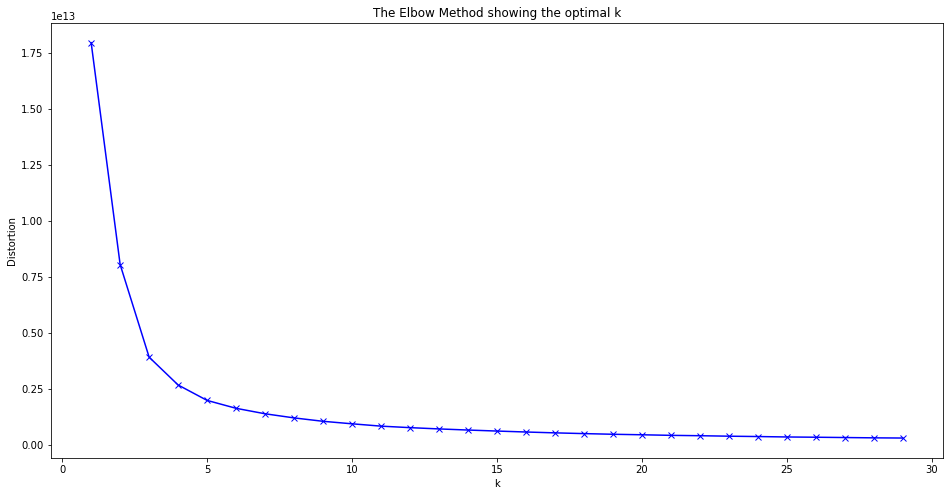

In [33]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### The plot suggests K = 3 to be the best, so let's pick that and create clusters

In [34]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_PCA)
df['Clusters'] = y_pred

#### Visualizing the Clusters

<AxesSubplot:xlabel='Clusters', ylabel='count'>

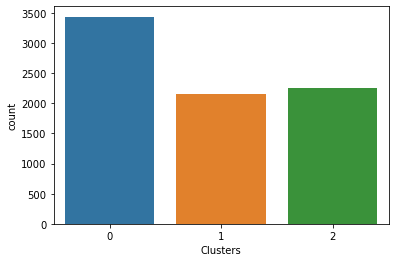

In [36]:
sns.countplot(df['Clusters'])

#### Creating a 2D plot where the axes represent a 2Drepresentation of each document, each document is represented as a marker, and the colour of the marker indicates the cluster to which the document belongs.

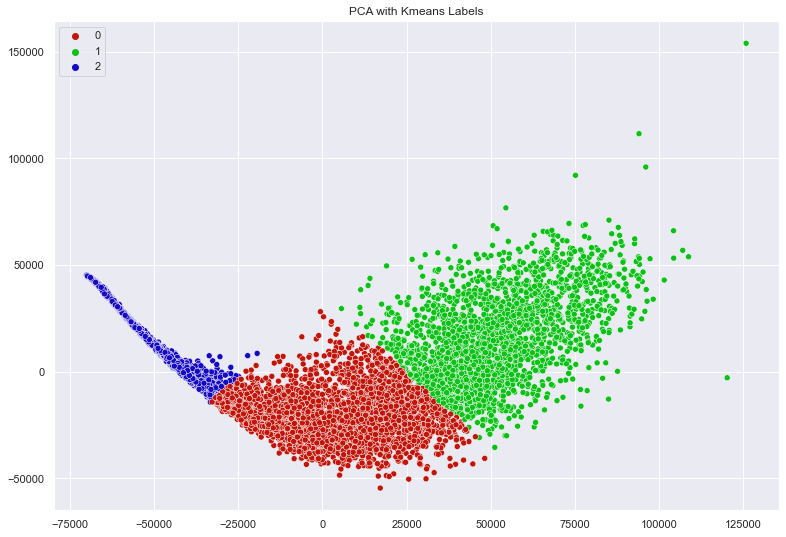

In [37]:
# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(3, l=.4, s=.9)

# plot
sns.scatterplot(X_PCA[:,0], X_PCA[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('PCA with Kmeans Labels')
plt.savefig("improved_cluster.png")
plt.show()

### 3 - For each cluster, what are the most representative words?
We create a word cloud for each cluster so that the size of each word in a word cloud represents the importance of the word in the corresponding cluster.
For example, we remove stop words, and remove other words that are common across all clusters.

#### We use our already cleaned data  to produce the wordcloud

In [38]:
wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words=200,max_font_size=40,random_state=42).generate(str(df['clean_abstract']))

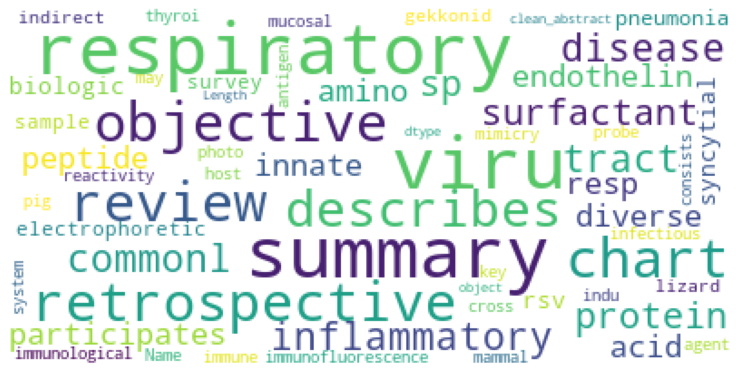

In [39]:
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

###4 - What are the most common topics?
We conduct topic modelling in order to identify the main topics of the opinions expressed in the abstracts. For example, we perform Latent Dirichlet Allocation. Presenting the results in the appropriate chart. To perform topic modelling we normally need to specify the number of topics. 

#### Getting the corpus od abstract column

In [40]:
data = df.clean_abstract.values.tolist()

#### Further preprocessing of data using gensim

In [41]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['objective', 'retrospective', 'chart', 'review', 'describes', 'epidemiology', 'clinical', 'feature', 'patient', 'culture', 'proven', 'mycoplasma', 'pneumoniae', 'infection', 'king', 'abdulaziz', 'university', 'hospital', 'jeddah', 'saudi', 'arabia', 'method', 'patient', 'positive', 'pneumoniae', 'culture', 'respiratory', 'specimen', 'january', 'december', 'identified', 'microbiology', 'record', 'chart', 'patient', 'result', 'patient', 'identified', 'required', 'admission', 'infection', 'community', 'acquired', 'infection', 'affected', 'age', 'group', 'common', 'infant', 'pre', 'school', 'child', 'occurred', 'year', 'round', 'common', 'fall', 'spring', 'three', 'quarter', 'patient', 'comorbidities', 'twenty', 'four', 'isolates', 'associated', 'pneumonia', 'upper', 'respiratory', 'tract', 'infection', 'bronchiolitis', 'cough', 'fever', 'malaise', 'common', 'symptom', 'crepitation', 'wheeze', 'common', 'sign', 'patient', 'pneumonia', 'crepitation', 'bronchial', 'breathing', 'patient', '

#### Performing lemmatization 

In [43]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [52]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) #select noun and verb
print(data_lemmatized[:2])

['objective retrospective chart review describe epidemiology clinical feature patient culture prove mycoplasma infection king method patient positive pneumoniae culture respiratory speciman identify microbiology record chart patient result patient identify require admission infection community acquire infection affect age group common infant pre school child occur year round common fall spring quarter patient comorbiditie isolate associate upper respiratory tract cough fever malaise common symptom crepitation wheeze common sign patient pneumonia bronchial breathing patient likely non patient present pneumonia patient pneumonia uneventful recovery recover follow complication die pneumoniae infection die due underlie comorbiditie patient die pneumonia comorbiditie conclusion result similar publish datum find infection common infant preschool child mortality rate pneumonia patient comorbiditie high', 'inflammatory disease respiratory tract commonly associate elevated production nitric oxi

#### Vectorizing data using CountVectorizer

In [53]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')   

data_vectorized = vectorizer.fit_transform(data_lemmatized)

#### Buildng an LDA Model

#### Since we had 3 clusters we will stick to 3 topics, to be able to make a comparison 

In [54]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=3,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=3, n_jobs=-1,
                          random_state=100)


#### Checking the Log Likelihood and Perplexity of our model

In [55]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -5528310.490689492
Perplexity:  1399.0859760236008
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 3,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


#### Getting top n keywords for each topic

In [56]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,disease,health,study,influenza,model,method,datum,base,result,provide,new,risk,human,population,high
Topic 1,patient,infection,respiratory,study,clinical,day,high,group,treatment,case,disease,result,associate,acute,lung
Topic 2,cell,virus,protein,infection,gene,viral,study,expression,response,human,induce,antibody,result,immune,activity


#### Labelling the 3 Topics

In [57]:
Topics = ["Covid Research","Health Risks and Treatment","Virus Behaviour"]

df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,disease,health,study,influenza,model,method,datum,base,result,provide,new,risk,human,population,high,Covid Research
Topic 1,patient,infection,respiratory,study,clinical,day,high,group,treatment,case,disease,result,associate,acute,lung,Health Risks and Treatment
Topic 2,cell,virus,protein,infection,gene,viral,study,expression,response,human,induce,antibody,result,immune,activity,Virus Behaviour


#### Defining a function to predict topic for a given text document.

In [59]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["Very Useful in diabetes age 30. I need control sugar. thanks Good deal"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)

print(infer_topic)

Covid Research


## 5 - What are the most common topics in each cluster?
Using the information from the topics to characterise the topics in each cluster.
What kind of information do we want to know? Here are some questions that we may want to answer:
1. Are there any topics that are more (or less) common in the clusters?
2. For each topic, what are the most representative clusters?
3. For each cluster, what are its most representative topics?

### Using the information from the topics of task 4 to characterise the topics in each cluster and adding it to the dataframe

In [60]:
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
df["Topic_key_word"]= df['abstract'].apply(apply_predict_topic)
df.head()

,abstract,clean_abstract,array,Clusters,Topic_key_word
0,OBJECTIVE: This retrospective chart review des...,objective retrospective chart review describes...,"[101, 7863, 15354, 3673, 3319, 5577, 4958, 517...",0,Health Risks and Treatment
1,Inflammatory diseases of the respiratory tract...,inflammatory disease respiratory tract commonl...,"[101, 20187, 4295, 16464, 12859, 4141, 3378, 8...",2,Virus Behaviour
2,Surfactant protein-D (SP-D) participates in th...,surfactant protein sp participates innate resp...,"[101, 14175, 18908, 4630, 5250, 11867, 17257, ...",1,Virus Behaviour
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...,endothelin amino acid peptide diverse biologic...,"[101, 2203, 14573, 18809, 13096, 5648, 25117, ...",2,Virus Behaviour
4,Respiratory syncytial virus (RSV) and pneumoni...,respiratory syncytial virus rsv pneumonia viru...,"[101, 16464, 26351, 22123, 4818, 7865, 12667, ...",2,Virus Behaviour


In [61]:
df

,abstract,clean_abstract,array,Clusters,Topic_key_word
0,OBJECTIVE: This retrospective chart review des...,objective retrospective chart review describes...,"[101, 7863, 15354, 3673, 3319, 5577, 4958, 517...",0,Health Risks and Treatment
1,Inflammatory diseases of the respiratory tract...,inflammatory disease respiratory tract commonl...,"[101, 20187, 4295, 16464, 12859, 4141, 3378, 8...",2,Virus Behaviour
2,Surfactant protein-D (SP-D) participates in th...,surfactant protein sp participates innate resp...,"[101, 14175, 18908, 4630, 5250, 11867, 17257, ...",1,Virus Behaviour
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...,endothelin amino acid peptide diverse biologic...,"[101, 2203, 14573, 18809, 13096, 5648, 25117, ...",2,Virus Behaviour
4,Respiratory syncytial virus (RSV) and pneumoni...,respiratory syncytial virus rsv pneumonia viru...,"[101, 16464, 26351, 22123, 4818, 7865, 12667, ...",2,Virus Behaviour
...,...,...,...,...,...
9994,An electrophoretic survey of samples of the ge...,electrophoretic survey sample gekkonid lizard ...,"[101, 16175, 8458, 5686, 4588, 5002, 7099, 162...",2,Covid Research
9995,SUMMARY: By indirect immunofluorescence on pig...,summary indirect immunofluorescence pig thyroi...,"[101, 12654, 14958, 10047, 23041, 11253, 7630,...",1,Health Risks and Treatment
9996,The cross‐reactivity of an immunological probe...,cross‐reactivity immunological probe key photo...,"[101, 2892, 1513, 10509, 7730, 10047, 23041, 1...",1,Virus Behaviour
9998,Summary: The mucosal immune system of mammals ...,summary mucosal immune system mammal consists ...,"[101, 12654, 14163, 13186, 2389, 11311, 2291, ...",1,Virus Behaviour


#### Plottting the 3 top topics

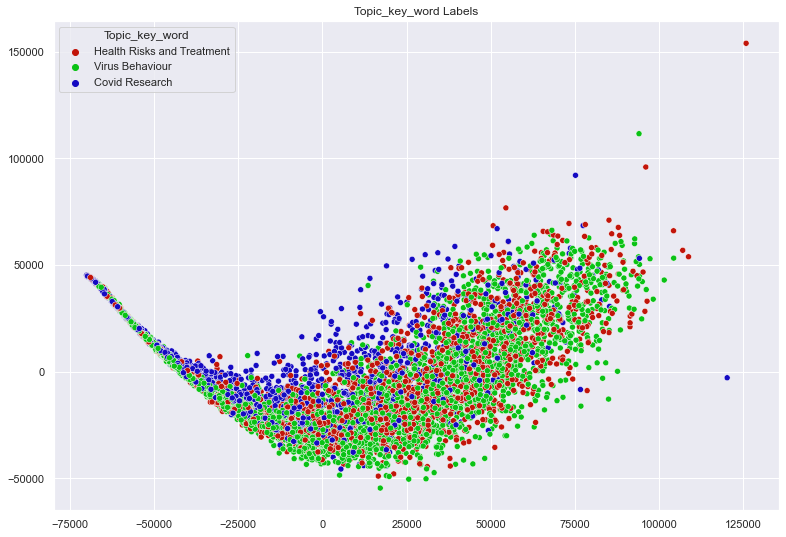

In [63]:
# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(3, l=.4, s=.9)

# plot
sns.scatterplot(X_PCA[:,0], X_PCA[:,1], hue=df['Topic_key_word'], legend='full', palette=palette)
plt.title('Topic_key_word Labels')
plt.savefig("improved_cluster.png")
plt.show()

#### Altough we used 3 Top topics, topic modelling worked quite differently in comparison to clustering, but was able to give us refined results

#### Comparing Kmeans clusters and Topics from Lda

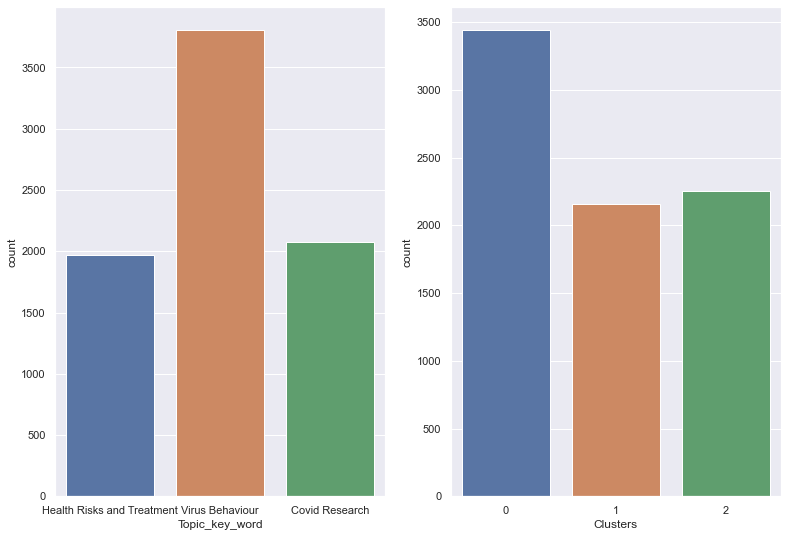

In [64]:
fig, ax =plt.subplots(1,2)
sns.countplot(df['Topic_key_word'], ax=ax[0])
sns.countplot(df['Clusters'], ax=ax[1])
fig.show()

#### The distribution is quite smiliar which is a positive sign..! Altough the behaviour of both the models is different 

## END